# WGAN of the MNIST dataset with KERAS

- For the overal architecture, I used [this code](https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py)
- I then improved it using some [GAN hacks](https://github.com/soumith/ganhacks)
- [Paper introducing WGAN](https://arxiv.org/abs/1701.07875)
- [Paper discussin WGAN](https://hal.inria.fr/hal-01850447/document)

![image](https://lilianweng.github.io/lil-log/assets/images/WGAN_algorithm.png)

Compared to the original GAN algorithm, the WGAN undertakes the following changes:

- After every gradient update on the critic function, clamp the weights to a small fixed range, [−c,c].
- Use a new loss function derived from the Wasserstein distance, no logarithm anymore. The “discriminator” model does not play as a direct critic but a helper for estimating the Wasserstein metric between real and generated data distribution.
- Empirically the authors recommended RMSProp optimizer on the critic, rather than a momentum based optimizer such as Adam which could cause instability in the model training. I haven’t seen clear theoretical explanation on this point through.

Source is [this post](https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html)

Nvidia's new unconditional GAN produces the best samples yet with no conditioning

'I've read a couple papers that mention this particular con (and I've seen it myself building a GAN to generate emojis) to conditional GANs: conditional GANs end up ignoring the noise variable from your latent space and rely entirely on your conditional input. This leads to a particular type of "mode collapse" where, sure, you might be generating different images given a different conditional input. But given the same conditional input, your generated images have little to no variation. And this isn't easily fixed with minibatch discrimination because you'll already have varying images per batch given a bunch of different conditional inputs.'

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
print(tf.__version__) # Tensorflow 1.1.0
print(keras.__version__) # Keras 2.0 is required here (revert to it if needed) otherwise LeakyRelu doesn't work

from keras.layers import Input, Concatenate, BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop
from keras import initializers
from keras.layers import Activation, Dense
import keras.backend as K

from sklearn.utils import shuffle

from IPython import display

import pandas as pd



Using TensorFlow backend.


1.1.0
2.0.0


C:\Users\mednche\AppData\Local\conda\conda\envs\kerasproject\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

#import random
#seed = random.randint(0,9999)
#random.seed(seed)

### Load MNIST data

In [20]:
# load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# normalize our inputs to be in the range[-1, 1]
X_train = (X_train.astype(np.float32) - 127.5)/127.5
# convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have 784 columns per row
X_train = X_train.reshape(60000, 784)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')


X_train shape: (60000, 784)
60000 training samples
10000 test samples


### Visualise MNIST data

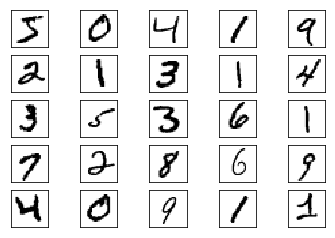

In [21]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(X_train.shape[0], 28, 28)[i], interpolation='nearest', cmap='gray_r')


In [22]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [23]:
def get_generator():
    
    random_dim = 100
    num_classes = 10
    
    generator = Sequential()
    generator.add(Dense(256, input_dim= random_dim + num_classes, kernel_initializer = 'uniform', bias_initializer = 'zeros'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Dense(512))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Dense(1024))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(alpha=0.2))

    generator.add(Dense(784, activation='tanh'))
    
    generator.summary()
    
    noise = Input(shape=(random_dim,))
    labels = Input(shape=(num_classes,))
    
    model_input = Concatenate()([noise, labels])
    
    img = generator(model_input)
    
    return Model([noise, labels], img)


In [24]:
def get_critic():
    
    num_classes = 10
    
    critic = Sequential()
    critic.add(Dense(1024, input_dim=784 + num_classes, kernel_initializer = 'uniform', bias_initializer = 'zeros'))
    #critic.add(BatchNormalization(momentum=0.8))
    critic.add(LeakyReLU(alpha=0.3))
    critic.add(Dropout(0.2))

    critic.add(Dense(512))
    #critic.add(BatchNormalization(momentum=0.8))
    critic.add(LeakyReLU(alpha=0.3))
    critic.add(Dropout(0.2))

    critic.add(Dense(256))
    #critic.add(BatchNormalization(momentum=0.8))
    critic.add(LeakyReLU(alpha=0.3))
    critic.add(Dropout(0.2))

    critic.add(Dense(1, activation='sigmoid'))  # removed sigmoid for WGAN
    
    img = Input(shape=(784,))
    labels = Input(shape=(num_classes,))
    model_input = Concatenate()([img, labels])

    validity = critic(model_input)

    return Model([img, labels], validity)

In [25]:
def get_gan_network():

    # Following parameter and optimizer set as recommended in paper
    optimizer = RMSprop(lr=0.00005)   
        
    D = get_critic()
    D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    G = get_generator()
    #G.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    
    noise = Input(shape=(100,))
    label = Input(shape=(10,))
    
    img = G([noise, label])
    
    D.trainable = False
    
    # get the output of the discriminator (probability of the image being real or not)
    valid = D([img, label])

    gan = Model([noise, label], valid) # inputs and outputs under keras version 2.2.2
    gan.compile(loss=wasserstein_loss, optimizer=optimizer, metrics=['accuracy'])
    
    return G, D, gan

###  A function which will save your generated images every 20 epochs

In [26]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, random_dim, examples=100, dim=(10, 10), figsize=(10, 10)):
    
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    labels = np.arange(10) # create labels from 0 to 9
    labels = np.asarray([one_hot_encode(x) for x in labels]) 
    
    generated_images = G.predict([noise, labels])  
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    

In [27]:
def one_hot_encode(y):
    z = np.zeros(10)
    #idx = np.arange(len(y))
    z[y] = 1
    return z

### Training the GAN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 256)               28416     
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_58 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_29 (Batc (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 1024)              525312    
__________

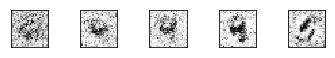

--------------- Epoch 2 ---------------
Cost of D after epoch 2: 0.669915
Cost of G after epoch 2: 0.051737
--------------- Epoch 3 ---------------
Cost of D after epoch 3: 0.658470
Cost of G after epoch 3: 0.052912
--------------- Epoch 4 ---------------
Cost of D after epoch 4: 0.665673
Cost of G after epoch 4: 0.052099
--------------- Epoch 5 ---------------
Cost of D after epoch 5: 0.662270
Cost of G after epoch 5: 0.051949
--------------- Epoch 6 ---------------
Cost of D after epoch 6: 0.666418
Cost of G after epoch 6: 0.052305
--------------- Epoch 7 ---------------
Cost of D after epoch 7: 0.668158
Cost of G after epoch 7: 0.051341
--------------- Epoch 8 ---------------
Cost of D after epoch 8: 0.678443
Cost of G after epoch 8: 0.052006
--------------- Epoch 9 ---------------
Cost of D after epoch 9: 0.677282
Cost of G after epoch 9: 0.052373
--------------- Epoch 10 ---------------
Cost of D after epoch 10: 0.674379
Cost of G after epoch 10: 0.052827


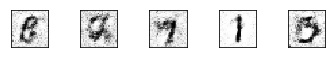

--------------- Epoch 11 ---------------
Cost of D after epoch 11: 0.677147
Cost of G after epoch 11: 0.052458
--------------- Epoch 12 ---------------
Cost of D after epoch 12: 0.674338
Cost of G after epoch 12: 0.052374
--------------- Epoch 13 ---------------
Cost of D after epoch 13: 0.684985
Cost of G after epoch 13: 0.051809
--------------- Epoch 14 ---------------
Cost of D after epoch 14: 0.681699
Cost of G after epoch 14: 0.052048
--------------- Epoch 15 ---------------
Cost of D after epoch 15: 0.677745
Cost of G after epoch 15: 0.051815
--------------- Epoch 16 ---------------
Cost of D after epoch 16: 0.680308
Cost of G after epoch 16: 0.052274
--------------- Epoch 17 ---------------
Cost of D after epoch 17: 0.688493
Cost of G after epoch 17: 0.051960
--------------- Epoch 18 ---------------
Cost of D after epoch 18: 0.681180
Cost of G after epoch 18: 0.052297
--------------- Epoch 19 ---------------
Cost of D after epoch 19: 0.675264
Cost of G after epoch 19: 0.052368
-

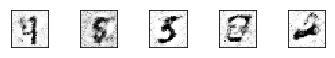

--------------- Epoch 21 ---------------
Cost of D after epoch 21: 0.683328
Cost of G after epoch 21: 0.052173
--------------- Epoch 22 ---------------
Cost of D after epoch 22: 0.685880
Cost of G after epoch 22: 0.052318
--------------- Epoch 23 ---------------
Cost of D after epoch 23: 0.685992
Cost of G after epoch 23: 0.052338
--------------- Epoch 24 ---------------
Cost of D after epoch 24: 0.684635
Cost of G after epoch 24: 0.052250
--------------- Epoch 25 ---------------
Cost of D after epoch 25: 0.684224
Cost of G after epoch 25: 0.052497
--------------- Epoch 26 ---------------
Cost of D after epoch 26: 0.686154
Cost of G after epoch 26: 0.052152
--------------- Epoch 27 ---------------
Cost of D after epoch 27: 0.686616
Cost of G after epoch 27: 0.052287
--------------- Epoch 28 ---------------
Cost of D after epoch 28: 0.687378
Cost of G after epoch 28: 0.052193
--------------- Epoch 29 ---------------
Cost of D after epoch 29: 0.686564
Cost of G after epoch 29: 0.052161
-

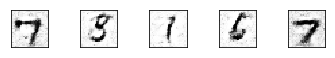

--------------- Epoch 31 ---------------
Cost of D after epoch 31: 0.685093
Cost of G after epoch 31: 0.051729
--------------- Epoch 32 ---------------
Cost of D after epoch 32: 0.692249
Cost of G after epoch 32: 0.052082
--------------- Epoch 33 ---------------
Cost of D after epoch 33: 0.684858
Cost of G after epoch 33: 0.052052
--------------- Epoch 34 ---------------
Cost of D after epoch 34: 0.683873
Cost of G after epoch 34: 0.052264
--------------- Epoch 35 ---------------
Cost of D after epoch 35: 0.687142
Cost of G after epoch 35: 0.052387
--------------- Epoch 36 ---------------
Cost of D after epoch 36: 0.686411
Cost of G after epoch 36: 0.051909
--------------- Epoch 37 ---------------
Cost of D after epoch 37: 0.686563
Cost of G after epoch 37: 0.052091
--------------- Epoch 38 ---------------
Cost of D after epoch 38: 0.687703
Cost of G after epoch 38: 0.051887
--------------- Epoch 39 ---------------
Cost of D after epoch 39: 0.685684
Cost of G after epoch 39: 0.051935
-

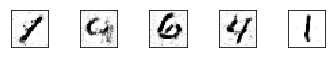

--------------- Epoch 41 ---------------
Cost of D after epoch 41: 0.689332
Cost of G after epoch 41: 0.052010
--------------- Epoch 42 ---------------
Cost of D after epoch 42: 0.688509
Cost of G after epoch 42: 0.052206
--------------- Epoch 43 ---------------
Cost of D after epoch 43: 0.689158
Cost of G after epoch 43: 0.051996
--------------- Epoch 44 ---------------
Cost of D after epoch 44: 0.687672
Cost of G after epoch 44: 0.052017
--------------- Epoch 45 ---------------
Cost of D after epoch 45: 0.690631
Cost of G after epoch 45: 0.051991
--------------- Epoch 46 ---------------
Cost of D after epoch 46: 0.689748
Cost of G after epoch 46: 0.052155
--------------- Epoch 47 ---------------
Cost of D after epoch 47: 0.687319
Cost of G after epoch 47: 0.051998
--------------- Epoch 48 ---------------
Cost of D after epoch 48: 0.687980
Cost of G after epoch 48: 0.052322
--------------- Epoch 49 ---------------
Cost of D after epoch 49: 0.690068
Cost of G after epoch 49: 0.052252
-

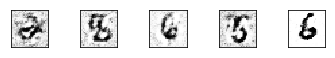

--------------- Epoch 51 ---------------
Cost of D after epoch 51: 0.689108
Cost of G after epoch 51: 0.052339
--------------- Epoch 52 ---------------
Cost of D after epoch 52: 0.688616
Cost of G after epoch 52: 0.052070
--------------- Epoch 53 ---------------
Cost of D after epoch 53: 0.687938
Cost of G after epoch 53: 0.052175
--------------- Epoch 54 ---------------
Cost of D after epoch 54: 0.686690
Cost of G after epoch 54: 0.052292
--------------- Epoch 55 ---------------
Cost of D after epoch 55: 0.690863
Cost of G after epoch 55: 0.052126
--------------- Epoch 56 ---------------
Cost of D after epoch 56: 0.689654
Cost of G after epoch 56: 0.051976
--------------- Epoch 57 ---------------
Cost of D after epoch 57: 0.688562
Cost of G after epoch 57: 0.052280
--------------- Epoch 58 ---------------
Cost of D after epoch 58: 0.692788
Cost of G after epoch 58: 0.052159
--------------- Epoch 59 ---------------
Cost of D after epoch 59: 0.689630
Cost of G after epoch 59: 0.052340
-

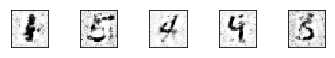

--------------- Epoch 61 ---------------
Cost of D after epoch 61: 0.690948
Cost of G after epoch 61: 0.052208
--------------- Epoch 62 ---------------
Cost of D after epoch 62: 0.690063
Cost of G after epoch 62: 0.052237
--------------- Epoch 63 ---------------
Cost of D after epoch 63: 0.690047
Cost of G after epoch 63: 0.052036
--------------- Epoch 64 ---------------
Cost of D after epoch 64: 0.686972
Cost of G after epoch 64: 0.052391
--------------- Epoch 65 ---------------
Cost of D after epoch 65: 0.687924
Cost of G after epoch 65: 0.052068
--------------- Epoch 66 ---------------
Cost of D after epoch 66: 0.689250
Cost of G after epoch 66: 0.052289
--------------- Epoch 67 ---------------
Cost of D after epoch 67: 0.688325
Cost of G after epoch 67: 0.052244
--------------- Epoch 68 ---------------
Cost of D after epoch 68: 0.688668
Cost of G after epoch 68: 0.052327
--------------- Epoch 69 ---------------
Cost of D after epoch 69: 0.691542
Cost of G after epoch 69: 0.052149
-

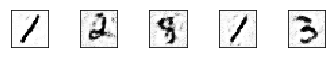

--------------- Epoch 71 ---------------
Cost of D after epoch 71: 0.688768
Cost of G after epoch 71: 0.052202
--------------- Epoch 72 ---------------
Cost of D after epoch 72: 0.690790
Cost of G after epoch 72: 0.052161
--------------- Epoch 73 ---------------
Cost of D after epoch 73: 0.690417
Cost of G after epoch 73: 0.052182
--------------- Epoch 74 ---------------
Cost of D after epoch 74: 0.690003
Cost of G after epoch 74: 0.052057
--------------- Epoch 75 ---------------
Cost of D after epoch 75: 0.690405
Cost of G after epoch 75: 0.052144
--------------- Epoch 76 ---------------
Cost of D after epoch 76: 0.689032
Cost of G after epoch 76: 0.052039
--------------- Epoch 77 ---------------
Cost of D after epoch 77: 0.689112
Cost of G after epoch 77: 0.052223
--------------- Epoch 78 ---------------
Cost of D after epoch 78: 0.689540
Cost of G after epoch 78: 0.051996
--------------- Epoch 79 ---------------
Cost of D after epoch 79: 0.687132
Cost of G after epoch 79: 0.052224
-

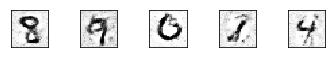

--------------- Epoch 81 ---------------
Cost of D after epoch 81: 0.688562
Cost of G after epoch 81: 0.052322
--------------- Epoch 82 ---------------
Cost of D after epoch 82: 0.689825
Cost of G after epoch 82: 0.052183
--------------- Epoch 83 ---------------
Cost of D after epoch 83: 0.689853
Cost of G after epoch 83: 0.052118
--------------- Epoch 84 ---------------
Cost of D after epoch 84: 0.690494
Cost of G after epoch 84: 0.052056
--------------- Epoch 85 ---------------
Cost of D after epoch 85: 0.689086
Cost of G after epoch 85: 0.052130
--------------- Epoch 86 ---------------
Cost of D after epoch 86: 0.688776
Cost of G after epoch 86: 0.052151
--------------- Epoch 87 ---------------
Cost of D after epoch 87: 0.689012
Cost of G after epoch 87: 0.052237
--------------- Epoch 88 ---------------
Cost of D after epoch 88: 0.687885
Cost of G after epoch 88: 0.052148
--------------- Epoch 89 ---------------
Cost of D after epoch 89: 0.689902
Cost of G after epoch 89: 0.052253
-

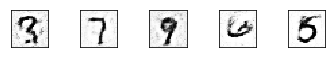

--------------- Epoch 91 ---------------
Cost of D after epoch 91: 0.690169
Cost of G after epoch 91: 0.052118
--------------- Epoch 92 ---------------
Cost of D after epoch 92: 0.690319
Cost of G after epoch 92: 0.052029
--------------- Epoch 93 ---------------
Cost of D after epoch 93: 0.688804
Cost of G after epoch 93: 0.052186
--------------- Epoch 94 ---------------
Cost of D after epoch 94: 0.688675
Cost of G after epoch 94: 0.052296
--------------- Epoch 95 ---------------
Cost of D after epoch 95: 0.688829
Cost of G after epoch 95: 0.052141
--------------- Epoch 96 ---------------
Cost of D after epoch 96: 0.690922
Cost of G after epoch 96: 0.052080
--------------- Epoch 97 ---------------
Cost of D after epoch 97: 0.688974
Cost of G after epoch 97: 0.052087
--------------- Epoch 98 ---------------
Cost of D after epoch 98: 0.692182
Cost of G after epoch 98: 0.052184
--------------- Epoch 99 ---------------
Cost of D after epoch 99: 0.688445
Cost of G after epoch 99: 0.052192
-

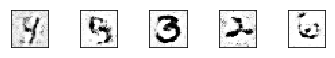

In [28]:
def train(X_train, y_train, x_test, y_test, epochs=100, minibatch_size=128, random_dim = 100):

# Build our GAN network
    G, D, gan = get_gan_network()
    
    # for plotting at the end
    D_loss = []
    G_loss = []
    
    # number of WHOLE minibatches 
    num_batches = int(X_train.shape[0]/minibatch_size)
    
    # Following parameter and optimizer set as recommended in paper
    n_critic = 4
    clip_value = 0.01
    
    
    # Adversarial ground truths
    valid = np.repeat(0.1, minibatch_size) # only for real images
    fake = np.ones((minibatch_size, 1))

    for epoch in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % epoch, '-'*15)
        
        # Defines a cost related to an epoch
        #epoch_cost = 0.                       
        
        
        # Randomize data point
        X_train, y_train = shuffle(X_train, y_train)
        
        
        for batch_idx in range(num_batches):
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
                
            for _ in range(n_critic):
                
                # Select a batch of images and labels
                legit_images = X_train[batch_idx*minibatch_size : (batch_idx+1)*minibatch_size].squeeze()
                true_labels = y_train[batch_idx*minibatch_size : (batch_idx+1)*minibatch_size]
                true_labels = np.asarray([one_hot_encode(x) for x in true_labels])

                # Train discriminator on real data
                D.trainable = True
                d_loss_real = D.train_on_batch([legit_images, true_labels], valid)
                
                # Generate a batch of new images
                noise = np.random.normal(0, 1, size=[minibatch_size, 100]) # random_dim = 100 here
                syntetic_images = G.predict([noise, true_labels])
                
                # Train discriminator on fake data
                d_loss_fake = D.train_on_batch([syntetic_images, true_labels], fake)
                
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
                
                # Clip critic weights (wgan)
                for l in D.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                    l.set_weights(weights)
                    

            
            # ---------------------
            #  Train Generator
            # ---------------------
            

            random_labels = np.asarray([one_hot_encode(x) for x in np.random.choice(10, minibatch_size)]) 
            
            D.trainable = False
            g_loss = gan.train_on_batch([noise, random_labels], valid) # fool D to think they are valid
        
        # At end of epoch, append latest value for losses
        D_loss.append(d_loss[0])
        G_loss.append(g_lossp[0])

            
        # Plot the progress
        #print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))
        print ("Cost of D after epoch %i: %f" % (epoch, d_loss[0]))
        print ("Cost of G after epoch %i: %f" % (epoch, g_loss[0]))
            
               
            
        if epoch == 1 or epoch % 10 == 0:
            
            # PLOT examples of 5 first synthetic images created by G
            for i in range(5):
                plt.subplot(5,5,i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(syntetic_images.reshape(int(minibatch_size), 28, 28)[i], interpolation='nearest', cmap='gray_r')
            plt.show()
            
            #plot_generated_images(e, G, random_dim)
            
    # Save models in case (creates a HDF5 file 'model.h5')    
    G.save_weights('Generator.h5') 
    D.save_weights('Discriminator.h5')
    
    return [D_loss, G_loss]
       
                  
            
            
if __name__ == '__main__':
    [D_loss, G_loss] = train(X_train, y_train, X_test, y_test, epochs = 100, minibatch_size=128, random_dim = 100) # random_dim = The dimension of our random noise vector.
    
    

### Visualise loss of D and G

In [29]:
ax = pd.DataFrame({'Generative Loss': G_loss, 'Discriminative Loss': D_loss,}).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

TypeError: Empty 'DataFrame': no numeric data to plot

### Load the saved models D and G

In [34]:
## Get the trained weights post training


#from keras.models import load_weights

# Returns a compiled model identical to the previous one
#adam = get_optimizer()
random_dim = 100
G1 = get_generator()
D1 = get_critic()


G1.load_weights('Generator.h5')
D1.load_weights('Discriminator.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 256)               28416     
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_35 (Batc (None, 512)               2048      
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 1024)              525312    
__________

### Examples of images produced by G

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


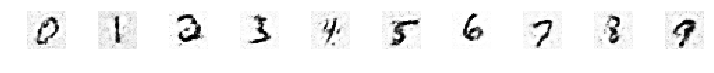

In [37]:
examples = 10
noise = np.random.normal(0, 1, size=[examples, random_dim])
labels = np.arange(10) # create labels from 0 to 9
labels = np.asarray([one_hot_encode(x) for x in labels]) 

print(labels)
generated_images = G1.predict([noise, labels])  
generated_images = generated_images.reshape(examples, 28, 28)

figsize=(10, 10)
dim=(10, 10)
plt.figure(figsize=figsize)
for i in range(generated_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
#plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

### Notes

It seems to work really well! But it is very slow (n_critic = 5). I'll try to reduce that number in the future and only increase it if needed


- Try with sigmoid activation in D
- try with batch norm in D
- try play with learning rate
- try change n_critic


